# Visulization of the OGB-MolPCBA Dataset

## Import Data

In [1]:
import os
import torch
import numpy as np
from gds.datasets.ogbmolhiv_dataset import OGBHIVDataset

In [2]:
# download  and process the dataset
root_dir = '/cmlscratch/kong/datasets/graph_domain'
dataset = OGBHIVDataset(root_dir=root_dir, model='gin')

In [3]:
# set variables
split_scheme = dataset._split_scheme
y_type = dataset._y_type 
y_size = dataset._y_size
n_classes = dataset._n_classes

In [4]:
# initialize data

# Here ogb_dataset.data is a torch_geometric.data.Data object
# See the docs at https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html?highlight=data.data.Data#torch_geometric.data.Data

# node features
x_array = dataset.ogb_dataset.data.x.data.numpy()

# graph connectivity
edge_index_array = dataset.ogb_dataset.data.edge_index.data.numpy()

# edge features
edge_attr_array = dataset.ogb_dataset.data.edge_attr.data.numpy()

# labels
y_array = dataset.ogb_dataset.data.y.data.numpy()

# train/val/test split
split_array = dataset._split_array

# scaffold (metadata)
scaffold_array = dataset._metadata_array_wo_y.squeeze()

# num of nodes in each graph
num_of_nodes_array = np.array([dataset[i][0].x.shape[0] for i in range(len(dataset))])

# num of edges in each graph
num_of_edges_array = np.array([dataset[i][0].edge_index.shape[1] for i in range(len(dataset))])

In [5]:
print('Shapes of variables:')
print('x: ', x_array.shape)
print('edge index: ', edge_index_array.shape)
print('edge attributes: ', edge_attr_array.shape)
print('y: ', y_array.shape)
print('split: ', split_array.shape)
print('scaffold: ', scaffold_array.shape)
print('num of nodes: ', num_of_nodes_array.shape)
print('num of edges: ', num_of_edges_array.shape)

Shapes of variables:
x:  (1049163, 9)
edge index:  (2, 2259376)
edge attributes:  (2259376, 3)
y:  (41127, 1)
split:  torch.Size([41127])
scaffold:  torch.Size([41127])
num of nodes:  (41127,)
num of edges:  (41127,)


In [6]:
print('Heads of these variables:')
print('x: \n', x_array[:5, :])
print('edge index: \n', edge_index_array[:, :5])
print('edge attributes: \n', edge_attr_array[:5, :])
print('y: \n', y_array[:5, :2])
print('split: \n', split_array[:10])
print('scaffold: \n', scaffold_array[:10])
print('num of nodes: \n', num_of_nodes_array[:10])
print('num of edges: \n', num_of_edges_array[:10])

Heads of these variables:
x: 
 [[ 5  0  4  5  3  0  2  0  0]
 [ 5  0  4  5  2  0  2  0  0]
 [ 5  0  3  5  0  0  1  0  1]
 [ 7  0  2  6  0  0  1  0  1]
 [28  0  4  2  0  0  5  0  1]]
edge index: 
 [[0 1 1 2 2]
 [1 0 2 1 3]]
edge attributes: 
 [[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]]
y: 
 [[0]
 [0]
 [0]
 [0]
 [0]]
split: 
 tensor([2, 2, 2, 0, 0, 0, 0, 2, 0, 0])
scaffold: 
 tensor([19088, 19087, 19086,     4,     1,     0,     0, 19085,    22,    22])
num of nodes: 
 [19 39 21 24 10 16 10 18 26 20]
num of edges: 
 [40 88 48 50 18 32 20 38 54 42]


### Generate Subsets of Train/Val/Test

First, understand the original train/val/test split ratios

In [7]:
num_of_train_graphs = np.where(split_array == 0)[0].shape[0]
num_of_val_graphs = np.where(split_array == 1)[0].shape[0]
num_of_test_graphs = np.where(split_array == 2)[0].shape[0]

print('Number of train/val/test graphs: ', num_of_train_graphs, '/', num_of_val_graphs, '/', num_of_test_graphs)
print('The train/val/test ratios: {:.4f} / {:.4f} / {:.4f}'.format(
    num_of_train_graphs/split_array.shape[0], 
    num_of_val_graphs/split_array.shape[0],
    num_of_test_graphs/split_array.shape[0]))

Number of train/val/test graphs:  32901 / 4113 / 4113
The train/val/test ratios: 0.8000 / 0.1000 / 0.1000


Then, we sample some graphs from train/val/test sets, and set the total number of graphs to 10000

In [8]:
# the number of samples randomly selected from the train/val/test sets
num_of_train_graphs = 8000
num_of_val_graphs = 1000
num_of_test_graphs = 1000
# find the scaffold indices for train/val/test sets
train_scaffold_array = np.unique(scaffold_array[np.where(split_array == 0)[0]])
val_scaffold_array = np.unique(scaffold_array[np.where(split_array == 1)[0]])
test_scaffold_array = np.unique(scaffold_array[np.where(split_array == 2)[0]])

print('Number of scaffolds in train/test/val: ', train_scaffold_array.shape[0], '/',
     val_scaffold_array.shape[0], '/', test_scaffold_array.shape[0])

Number of scaffolds in train/test/val:  10863 / 4113 / 4113


These numbers match what it is in the paper (page 82 of https://arxiv.org/pdf/2012.07421.pdf)

And actually the train/val/test scaffold indices are just 0 ~ 44929 / 44930 ~ 76920 / 76921 ~ 120083

In [9]:
print('Train scaffold indices: ', train_scaffold_array)
print('Val scaffold indices: ', val_scaffold_array)
print('Test scaffold indices: ', test_scaffold_array)

Train scaffold indices:  [    0     1     2 ... 10860 10861 10862]
Val scaffold indices:  [10863 10864 10865 ... 14973 14974 14975]
Test scaffold indices:  [14976 14977 14978 ... 19086 19087 19088]


Now we want to sample scaffolds in train/test/val so that the total number of graphs in train/test/val is (or maybe a little bit larger) than 8000/1000/1000

In [10]:
# general procedure to sample for train/test/val
def sample_graphs(splitted_scaffold_array, num_of_graphs):
    # fix random seed to 0
    # i strongly recommend we use the same random seed 0 here to generated the selected indices
    np.random.seed(0)
    selected_graph_indices = np.array([], dtype=np.int64)
    for selected_scaffold_index in np.random.choice(splitted_scaffold_array, size=num_of_graphs, replace=False):
        selected_graph_indices = np.append(selected_graph_indices, np.where(scaffold_array == selected_scaffold_index)[0])
        if selected_graph_indices.shape[0] >= num_of_graphs:
            break
    return selected_graph_indices

# generate graph indices
sel_train_graph_idx = sample_graphs(train_scaffold_array, num_of_train_graphs)
sel_val_graph_idx = sample_graphs(val_scaffold_array, num_of_val_graphs)
sel_test_graph_idx = sample_graphs(test_scaffold_array, num_of_test_graphs)

# number of graphs now in the selected train/val/test subsets
print('Number of selected train/val/test graphs: ', sel_train_graph_idx.shape[0], '/',
      sel_val_graph_idx.shape[0], '/', sel_test_graph_idx.shape[0])

# if you want to doble check, check the heads of these three list of indices
print('Train graph indices start with: ', sel_train_graph_idx[:10])
print('Val graph indices start with: ', sel_val_graph_idx[:10])
print('Test graph indices start with: ', sel_test_graph_idx[:10])

Number of selected train/val/test graphs:  8000 / 1000 / 1000
Train graph indices start with:  [  104  5441 15340 15341 16462 22874 28646 28647 28730 35203]
Val graph indices start with:  [11954 21733 22179 12397 15375 15873 13957 13520 20668 15299]
Test graph indices start with:  [2151 9296 9576 2634 5195 5636 4104 3712 8600 5133]


In [11]:
# dump the selected graph indices to file
# np.save('sel_train_graph_idx.npy', sel_train_graph_idx)
# np.save('sel_val_graph_idx.npy', sel_val_graph_idx)
# np.save('sel_test_graph_idx.npy', sel_test_graph_idx)

We are happy that we got exactly 8000/1000/1000 graphs in the new train/val/test sets

In [12]:
# now find the selected scaffold indices
sel_train_scaffold_idx = np.unique(scaffold_array[sel_train_graph_idx])
sel_val_scaffold_idx = np.unique(scaffold_array[sel_val_graph_idx])
sel_test_scaffold_idx = np.unique(scaffold_array[sel_test_graph_idx])

print('Number of selected train/val/test scaffolds: ', sel_train_scaffold_idx.shape[0], '/',
      sel_val_scaffold_idx.shape[0], '/', sel_test_scaffold_idx.shape[0])

Number of selected train/val/test scaffolds:  3103 / 1000 / 1000


It is not surprising that we selected 1000 test scaffolds, because each test scaffold has only 1 graph.

### Scatter Vis

In [13]:
import seaborn as sns
sns.set_theme(style="white")
from sklearn.manifold import MDS
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, MultiscaleLaplacian, SubgraphMatching, VertexHistogram, RandomWalkLabeled
import networkx as nx

gk = WeisfeilerLehman(n_jobs=8, verbose=False, normalize=True, n_iter=3, base_graph_kernel=VertexHistogram)
node_index_ranges = np.pad(np.cumsum(num_of_nodes_array), (1,0))
edge_index_ranges = np.pad(np.cumsum(num_of_edges_array), (1,0))

def parse_graph(graph_idx):
    edge_list = edge_index_array[:,edge_index_ranges[graph_idx]:edge_index_ranges[graph_idx+1]].T
    g = nx.Graph([tuple(e) for e in edge_list])
    # set the node features
    x = x_array[node_index_ranges[graph_idx]:node_index_ranges[graph_idx+1],:]
    nx.set_node_attributes(g, {node: x[node, 0] for node in g}, 'attributes')
    # set the edge features (TODO later)
    nx.set_edge_attributes(g, [], "attributes")
    return g

In [14]:
start_idx = 4
scaffold_idx_array = np.sort(sel_train_scaffold_idx)[start_idx:start_idx+3]
graph_idx_array = []
for scaffold_idx in scaffold_idx_array:
    graph_idx_array.append(np.where(scaffold_array == scaffold_idx)[0])
graph_idx_array = np.concatenate(graph_idx_array)
train_len_graph_idx_array = len(graph_idx_array)
print('Train size:', len(graph_idx_array))

Train size: 174


In [15]:
test_scaffold_idx_array = np.sort(sel_test_scaffold_idx)[:40]
test_graph_idx_array = []
for scaffold_idx in test_scaffold_idx_array:
    test_graph_idx_array.append(np.where(scaffold_array == scaffold_idx)[0])
test_graph_idx_array = np.concatenate(test_graph_idx_array)
print('Test size:', len(test_graph_idx_array))

graph_idx_array = np.concatenate([graph_idx_array, test_graph_idx_array])

Test size: 40


In [16]:
G_array = list(graph_from_networkx([parse_graph(idx) for idx in graph_idx_array], 
                                   node_labels_tag='attributes', edge_labels_tag='attributes'))
sim_matrix = gk.fit_transform(G_array)

/cmlscratch/kong/anaconda3/envs/graph-domain/lib/python3.7/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


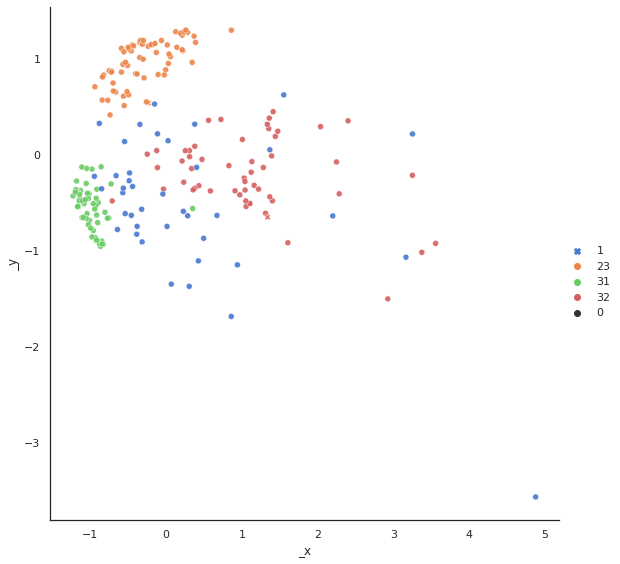

In [17]:
mds = MDS(n_components=2)
embedding = mds.fit_transform(sim_matrix)
# color map
color_map = [scaffold_array[graph_idx].item() for graph_idx in graph_idx_array[:train_len_graph_idx_array]]
test_color_map = [1 for _ in graph_idx_array[train_len_graph_idx_array:]]
color_map += test_color_map

sns.relplot(x=embedding[:,0], y=embedding[:,1], hue=color_map, style=y_array[graph_idx_array].squeeze(),
            sizes=(40, 400), alpha=.9, palette="muted", height=8)

### Relative Distances

In [24]:
def compute_ratio(start_idx) :
    scaffold_idx_array = np.sort(sel_train_scaffold_idx)[start_idx:start_idx+100]
    graph_idx_list = []
    for scaffold_idx in scaffold_idx_array:
        graph_idx_list.append(np.where(scaffold_array == scaffold_idx)[0])
    graph_idx_array = np.concatenate(graph_idx_list)
    print('Total graph num:', len(graph_idx_array))
    G_array = list(graph_from_networkx([parse_graph(idx) for idx in graph_idx_array], 
                                       node_labels_tag='attributes', edge_labels_tag='attributes'))
    sim_matrix = gk.fit_transform(G_array)
    
    
    total = np.sum(sim_matrix)
    num_of_graphs_list = [len(i) for i in graph_idx_list]
    graph_ranges = np.pad(np.cumsum(num_of_graphs_list), (1,0))
    
    in_sca = 0
    for i in range(len(graph_idx_list)) :
        in_sca += np.sum(sim_matrix[graph_ranges[i]:graph_ranges[i+1], graph_ranges[i]:graph_ranges[i+1]])
    
    in_num = 0
    for num in num_of_graphs_list :
        in_num += num**2
    in_num -= sim_matrix.shape[0]
    
    total_num = sim_matrix.shape[0]**2 - sim_matrix.shape[0]
    
    avg_in_sca = in_sca/in_num
    out_num = total_num - in_num
    out_total = total - in_sca
    avg_out_sca = out_total/out_num
    
    print('Across over within:', avg_out_sca/avg_in_sca)
    return avg_out_sca/avg_in_sca

In [25]:
result_list = [compute_ratio(i) for i in range(50, 250, 50)]
result_array = np.array(result_list)
print(result_array)

print(f'{np.mean(result_array)}, {np.std(result_array)}')

Total graph num: 1128
101
Across over within: 0.7773040094556981
Total graph num: 840
101
Across over within: 0.7482137431104573
Total graph num: 660
101
Across over within: 0.7106843241593631
Total graph num: 541
101
Across over within: 0.6754624859619472
[0.77730401 0.74821374 0.71068432 0.67546249]
0.7279161406718664, 0.03840402205665467
